In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t as tdist
sns.set(style='whitegrid', context='talk')

In [65]:
# === LOAD DATA ===
df = pd.read_csv(r'data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').sort_index()

# Compute risk-free rate (monthly) and lag
rf = df['TB1M']/100/250
rf_lag = rf.shift(1)

# Remove RF column from price data
prices = df.drop(columns=['TB1M'])

# Simple returns
returns = prices / prices.shift(1) - 1

# Risk premia
RP = returns.sub(rf_lag, axis=0).rename(columns={'OEX':'OEX_rp'})

# Drop NA
RP_aligned = RP.dropna(how='any')

RP_aligned.head()
# print(RP_aligned['OEX_rp'].mean())

,OEX_rp,AAPL,ABT,ADBE,AIG,AMD,AMGN,AMT,AMZN,AXP,...,TMO,TXN,UNH,UNP,UPS,USB,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.037973,-0.084529,-0.028790,-0.084109,-0.051332,-0.056671,-0.076684,-0.010880,-0.083436,-0.037978,...,-0.037719,-0.042747,-0.013010,-0.001671,-0.031906,-0.036694,-0.032544,-0.049740,-0.037637,-0.019373
2000-01-05,0.003090,0.014416,-0.002055,0.019554,0.002159,0.025424,0.034192,0.029955,-0.148959,-0.025616,...,0.008441,-0.024329,-0.002573,-0.000217,0.046943,-0.022299,0.033188,-0.010301,-0.020626,0.054299
2000-01-06,0.001253,-0.086756,0.034773,0.007946,0.030287,0.066449,0.016415,-0.010678,-0.060253,0.020156,...,-0.000218,-0.027525,0.036382,0.060829,-0.000218,0.077202,-0.005297,0.043924,0.010695,0.051480
2000-01-07,0.027123,0.047152,0.010460,0.048367,0.074631,0.015409,0.112258,0.054752,0.060794,0.014343,...,0.012659,0.005131,0.117096,-0.007066,-0.024113,0.038706,-0.007601,0.017670,0.075348,-0.003151
2000-01-10,0.009268,-0.017804,-0.007258,0.038395,-0.017909,0.076708,0.060447,0.087961,-0.005606,0.013725,...,-0.008690,0.068269,-0.017545,0.023234,0.010143,-0.005979,-0.005528,-0.032164,-0.018464,-0.014196


In [137]:
def excel_first_pass(RP,start,end):
    RP=RP.loc[start:end]
    RM=RP['OEX_rp']
    rows=[]
    for s in RP.columns:
        if s=='OEX_rp': continue
        Ri=RP[s]
        cov=np.cov(Ri,RM)[0,1]
        var=np.var(RM,ddof=1)
        beta=cov/var
        alpha=Ri.mean()-beta*RM.mean()
        sigma2=np.var(Ri-beta*RM)
        rows.append([s,beta,alpha,sigma2,Ri.mean()])
    return pd.DataFrame(rows,columns=['Ticker','beta','alpha','sigma2','riskprem_mean'])

first = excel_first_pass(RP_m_aligned,'2000-03-31','2023-01-31')
print(first)

valid=first.set_index('Ticker')
y=valid['riskprem_mean']
X1=sm.add_constant(valid[['beta']])
model1=sm.OLS(y,X1).fit()
X2=sm.add_constant(valid[['beta','sigma2']])
model2=sm.OLS(y,X2).fit()
from IPython.display import display
display(model1.summary())
display(model2.summary())

   Ticker      beta     alpha    sigma2  riskprem_mean
0    AAPL  1.429353  0.020068  0.008846       0.024418
1     ABT  0.506101  0.008379  0.002725       0.009920
2    ADBE  1.391087  0.009507  0.006155       0.013741
3     AIG  1.726473  0.001657  0.037269       0.006912
4     AMD  2.382676  0.013879  0.024786       0.021131
..    ...       ...       ...       ...            ...
75    USB  0.889078  0.005187  0.003669       0.007893
76     VZ  0.636836  0.002305  0.003071       0.004243
77    WFC  0.944327  0.005395  0.004981       0.008269
78    WMT  0.444610  0.004297  0.002496       0.005650
79    XOM  0.692370  0.005327  0.003059       0.007434

[80 rows x 5 columns]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          riskprem_mean   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     8.203
Date:                Sun, 07 Dec 2025   Prob (F-statistic):            0.00537
Time:                        19:38:52   Log-Likelihood:                 310.45
No. Observations:                  80   AIC:                            -616.9
Df Residuals:                      78   BIC:                            -612.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.001      4.602      0.000       0.004       0.009
beta           0.0038      0.001      2.864      0.005       0.001       0.007
==============================================================================
Omnibus:                        7.061   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                6.956
Skew:                           0.515   Prob(JB):                       0.0309
Kurtosis:                       4.012   Cond. No.                         4.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          riskprem_mean   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     8.696
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           0.000393
Time:                        19:38:52   Log-Likelihood:                 314.60
No. Observations:                  80   AIC:                            -623.2
Df Residuals:                      77   BIC:                            -616.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0076      0.001      5.421      0.000       0.005       0.010
beta           0.0006      0.002      0.370      0.712      -0.003       0.004
sigma2         0.3584      0.124      2.900      0.005       0.112       0.605
==============================================================================
Omnibus:                        5.433   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                7.430
Skew:                           0.155   Prob(JB):                       0.0244
Kurtosis:                       4.461   Cond. No.                         326.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [138]:
print('=== CAPM HYPOTHESIS TESTS ===')
market_rp = RP_m_aligned['OEX_rp'].mean()
n = valid.shape[0]

# Model 1
gamma1_1 = model1.params['beta']
se1 = model1.bse['beta']
df1 = n - 2
t1 = (gamma1_1 - market_rp)/se13
p1 = 2*(1 - tdist.cdf(abs(t1), df1))
print('\nModel 1 (beta only)')
print('gamma1 =',gamma1_1)
print('market rp =',market_rp)
print('t-stat =',t1)
print('p-value =',p1)

# Model 2
gamma1_2 = model2.params['beta']
se2 = model2.bse['beta']
df2 = n - 3
t2 = (gamma1_2 - market_rp)/se2
p2 = 2*(1 - tdist.cdf(abs(t2), df2))
print('\nModel 2 (beta + sigma2)')
print('gamma1 =',gamma1_2)
print('market rp =',market_rp)
print('t-stat =',t2)
print('p-value =',p2)

=== CAPM HYPOTHESIS TESTS ===

Model 1 (beta only)
gamma1 = 0.0038431948501229463
market rp = 0.004302551865765611
t-stat = -0.3423245613294067
p-value = 0.7330273745486919

Model 2 (beta + sigma2)
gamma1 = 0.0006275799739831566
market rp = 0.004302551865765611
t-stat = -2.167807830048274
p-value = 0.03326304557113424


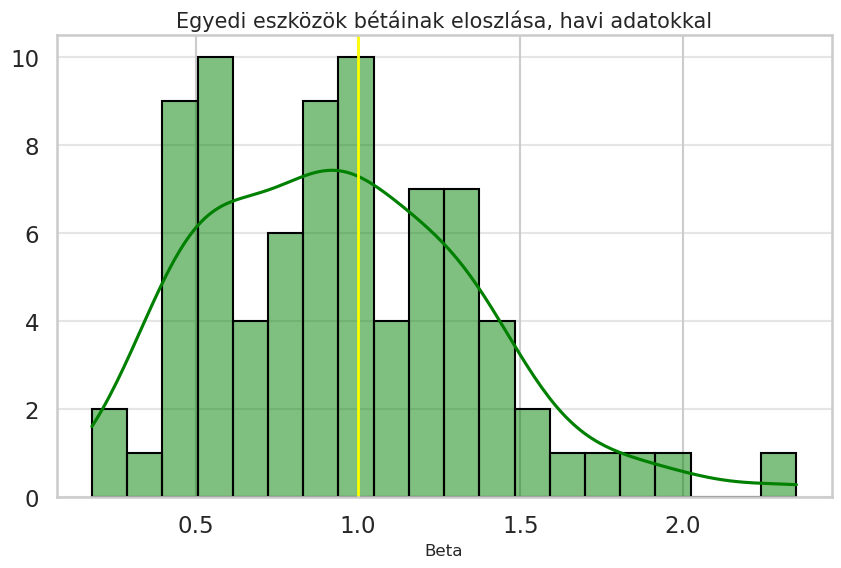

First-pass regresszió eredményei (első 5 sor):
  Ticker      beta     alpha    sigma2  riskprem_mean
0   AAPL  1.374741  0.017917  0.008275       0.023920
1    ABT  0.510924  0.006916  0.002736       0.009147
2   ADBE  1.333599  0.008939  0.008774       0.014762
3    AIG  1.602294 -0.000667  0.033977       0.006330
4    AMD  2.349371  0.013656  0.024338       0.023915
Beta átlaga: 0.9476643435727915


In [149]:
first_pass_results = excel_first_pass(RP_m_aligned, '2000-01-01', '2025-11-01')

# Hisztogram készítése
plt.figure(figsize=(10, 6))
sns.histplot(data=first_pass_results, x='beta', bins=20, kde=True, color='green', edgecolor='black')

# Díszítés
plt.title('Egyedi eszközök bétáinak eloszlása, havi adatokkal', fontsize=15)
plt.xlabel('Beta', fontsize=12)
plt.ylabel('')
plt.axvline(x=1, color='yellow', linewidth=2)
plt.grid(axis='y', alpha=0.5)
plt.savefig('src/betaeloszl-monthly2000-2025.svg')
plt.show()

# Eredmények kiírása ellenőrzésképp
print("First-pass regresszió eredményei (első 5 sor):")
print(first_pass_results.head())
print(f"Beta átlaga: {np.mean(first_pass_results['beta'])}")

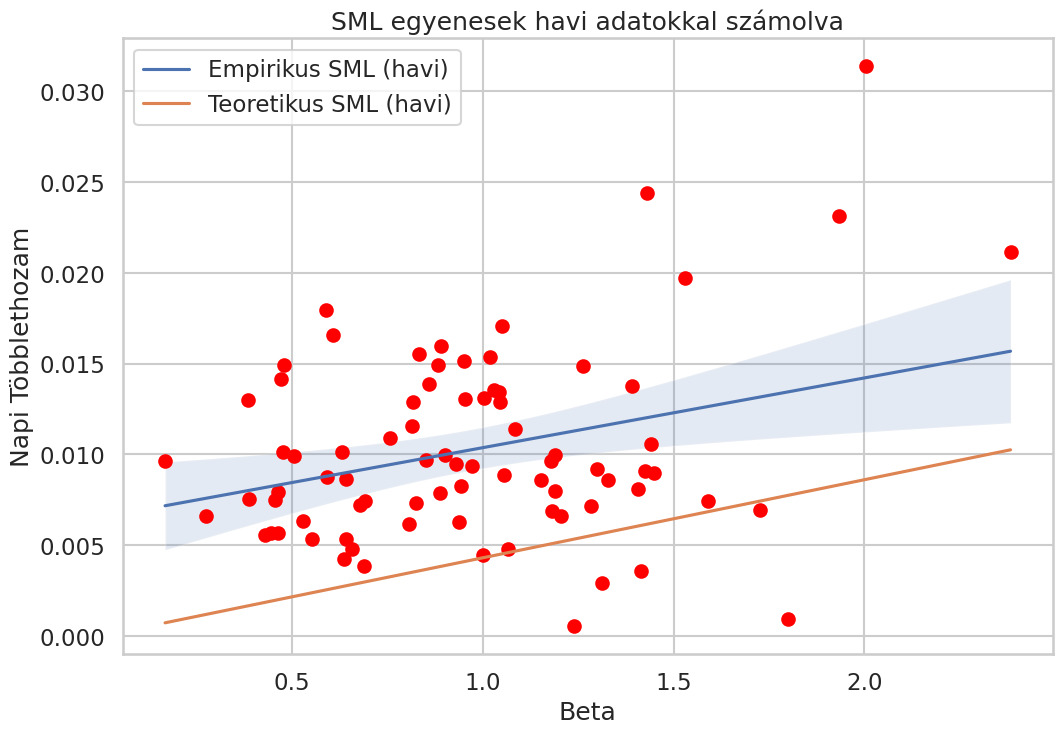

In [143]:
betas=valid['beta']; y_m=valid['riskprem_mean']
beta_grid=np.linspace(betas.min(), betas.max(),200)
X_pred=sm.add_constant(beta_grid)
pred=model1.get_prediction(X_pred)
ci=pred.conf_int(); y_pred=pred.predicted_mean
lower,upper=ci[:,0],ci[:,1]
plt.figure(figsize=(12,8))
plt.plot(beta_grid,y_pred,label='Empirikus SML (havi)')
plt.fill_between(beta_grid,lower,upper,alpha=0.15)
plt.plot(beta_grid,RP_m_aligned['OEX_rp'].mean()*beta_grid,label='Teoretikus SML (havi)')
plt.scatter(betas,y_m,color='red')
#for t in betas.index: plt.text(betas[t],y_m[t]+0.00005,t,ha='center')
plt.title("SML egyenesek havi adatokkal számolva")
plt.xlabel('Beta'); plt.ylabel('Napi Többlethozam'); plt.legend(); plt.savefig("src/SML.svg")
plt.show()

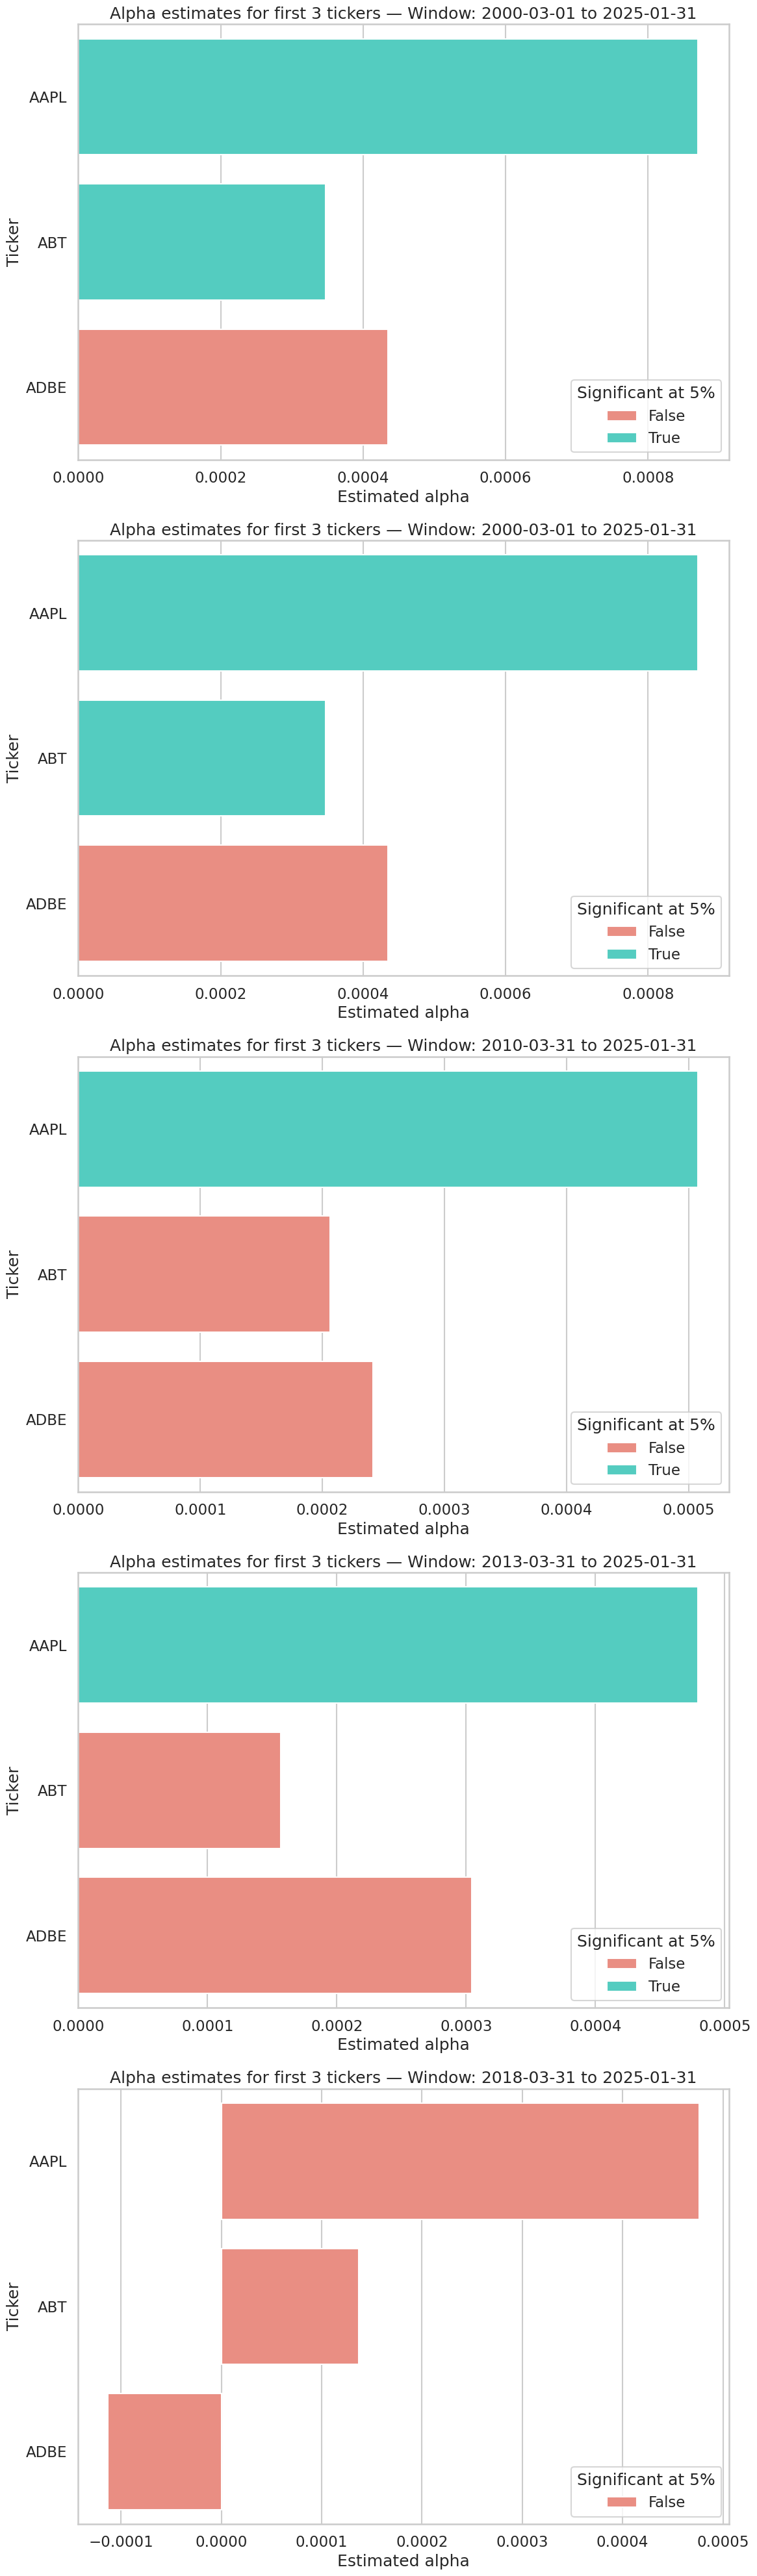

In [108]:
# === MULTI-WINDOW ANALYSIS ===
def excel_first_pass(RP, start, end):
    RPsub = RP.loc[start:end]
    RM = RPsub['OEX_rp']
    rows = []
    for s in RPsub.columns:
        if s == 'OEX_rp':
            continue
        Ri = RPsub[s]
        cov = np.cov(Ri, RM)[0,1]
        var = np.var(RM, ddof=1)
        beta = cov/var
        alpha = Ri.mean() - beta * RM.mean()
        sigma2 = np.var(Ri - beta*RM)
        rows.append([s, beta, alpha, sigma2, Ri.mean()])
    return pd.DataFrame(rows, columns=['Ticker','beta','alpha','sigma2','riskprem_mean'])

END = "2025-01-31"
starts = [
    "2000-03-01",
    "2000-03-01",
    "2010-03-31",
    "2013-03-31",
    "2018-03-31"
]

fig, axes = plt.subplots(5, 1, figsize=(12, 40))
plt.subplots_adjust(hspace=0.5)

for idx, start in enumerate(starts):
    first = excel_first_pass(RP_aligned, start, END)
    first = first.dropna()

    # Select first 3 tickers
    top3 = first.iloc[:3].copy()

    RM = RP_aligned['OEX_rp'].loc[start:END]
    RM_mean = RM.mean()
    RM_var = RM.var(ddof=1)
    N = len(RM)

    # Alpha SE
    top3['alpha_se'] = np.sqrt(top3['sigma2'] * (1 + (RM_mean**2)/RM_var) / N)

    # t-stats and p-values
    top3['tstat'] = top3['alpha'] / top3['alpha_se']
    top3['pval'] = 2 * (1 - tdist.cdf(np.abs(top3['tstat']), df=N-2))
    top3['significant'] = top3['pval'] < 0.05

    ax = axes[idx]
    sns.barplot(
        data=top3,
        x='alpha',
        y='Ticker',
        hue='significant',
        palette={True:'turquoise', False:'salmon'},
        ax=ax
    )

    ax.set_title(f"Alpha estimates for first 3 tickers — Window: {start} to {END}")
    ax.set_xlabel("Estimated alpha")
    ax.set_ylabel("Ticker")
    ax.legend(title="Significant at 5%")

plt.tight_layout()
#plt.show()

In [104]:
# === FIRST PASS FUNCTION ===
def excel_first_pass(RP, start, end):
    RPsub = RP.loc[start:end]
    RM = RPsub['OEX_rp']
    rows = []
    for s in RPsub.columns:
        if s == 'OEX_rp':
            continue
        Ri = RPsub[s]
        cov = np.cov(Ri, RM)[0,1]
        var = np.var(RM, ddof=1)
        beta = cov/var
        alpha = Ri.mean() - beta * RM.mean()
        sigma2 = np.var(Ri - beta*RM)
        rows.append([s, beta, alpha, sigma2, Ri.mean()])
    return pd.DataFrame(rows, columns=['Ticker','beta','alpha','sigma2','riskprem_mean'])

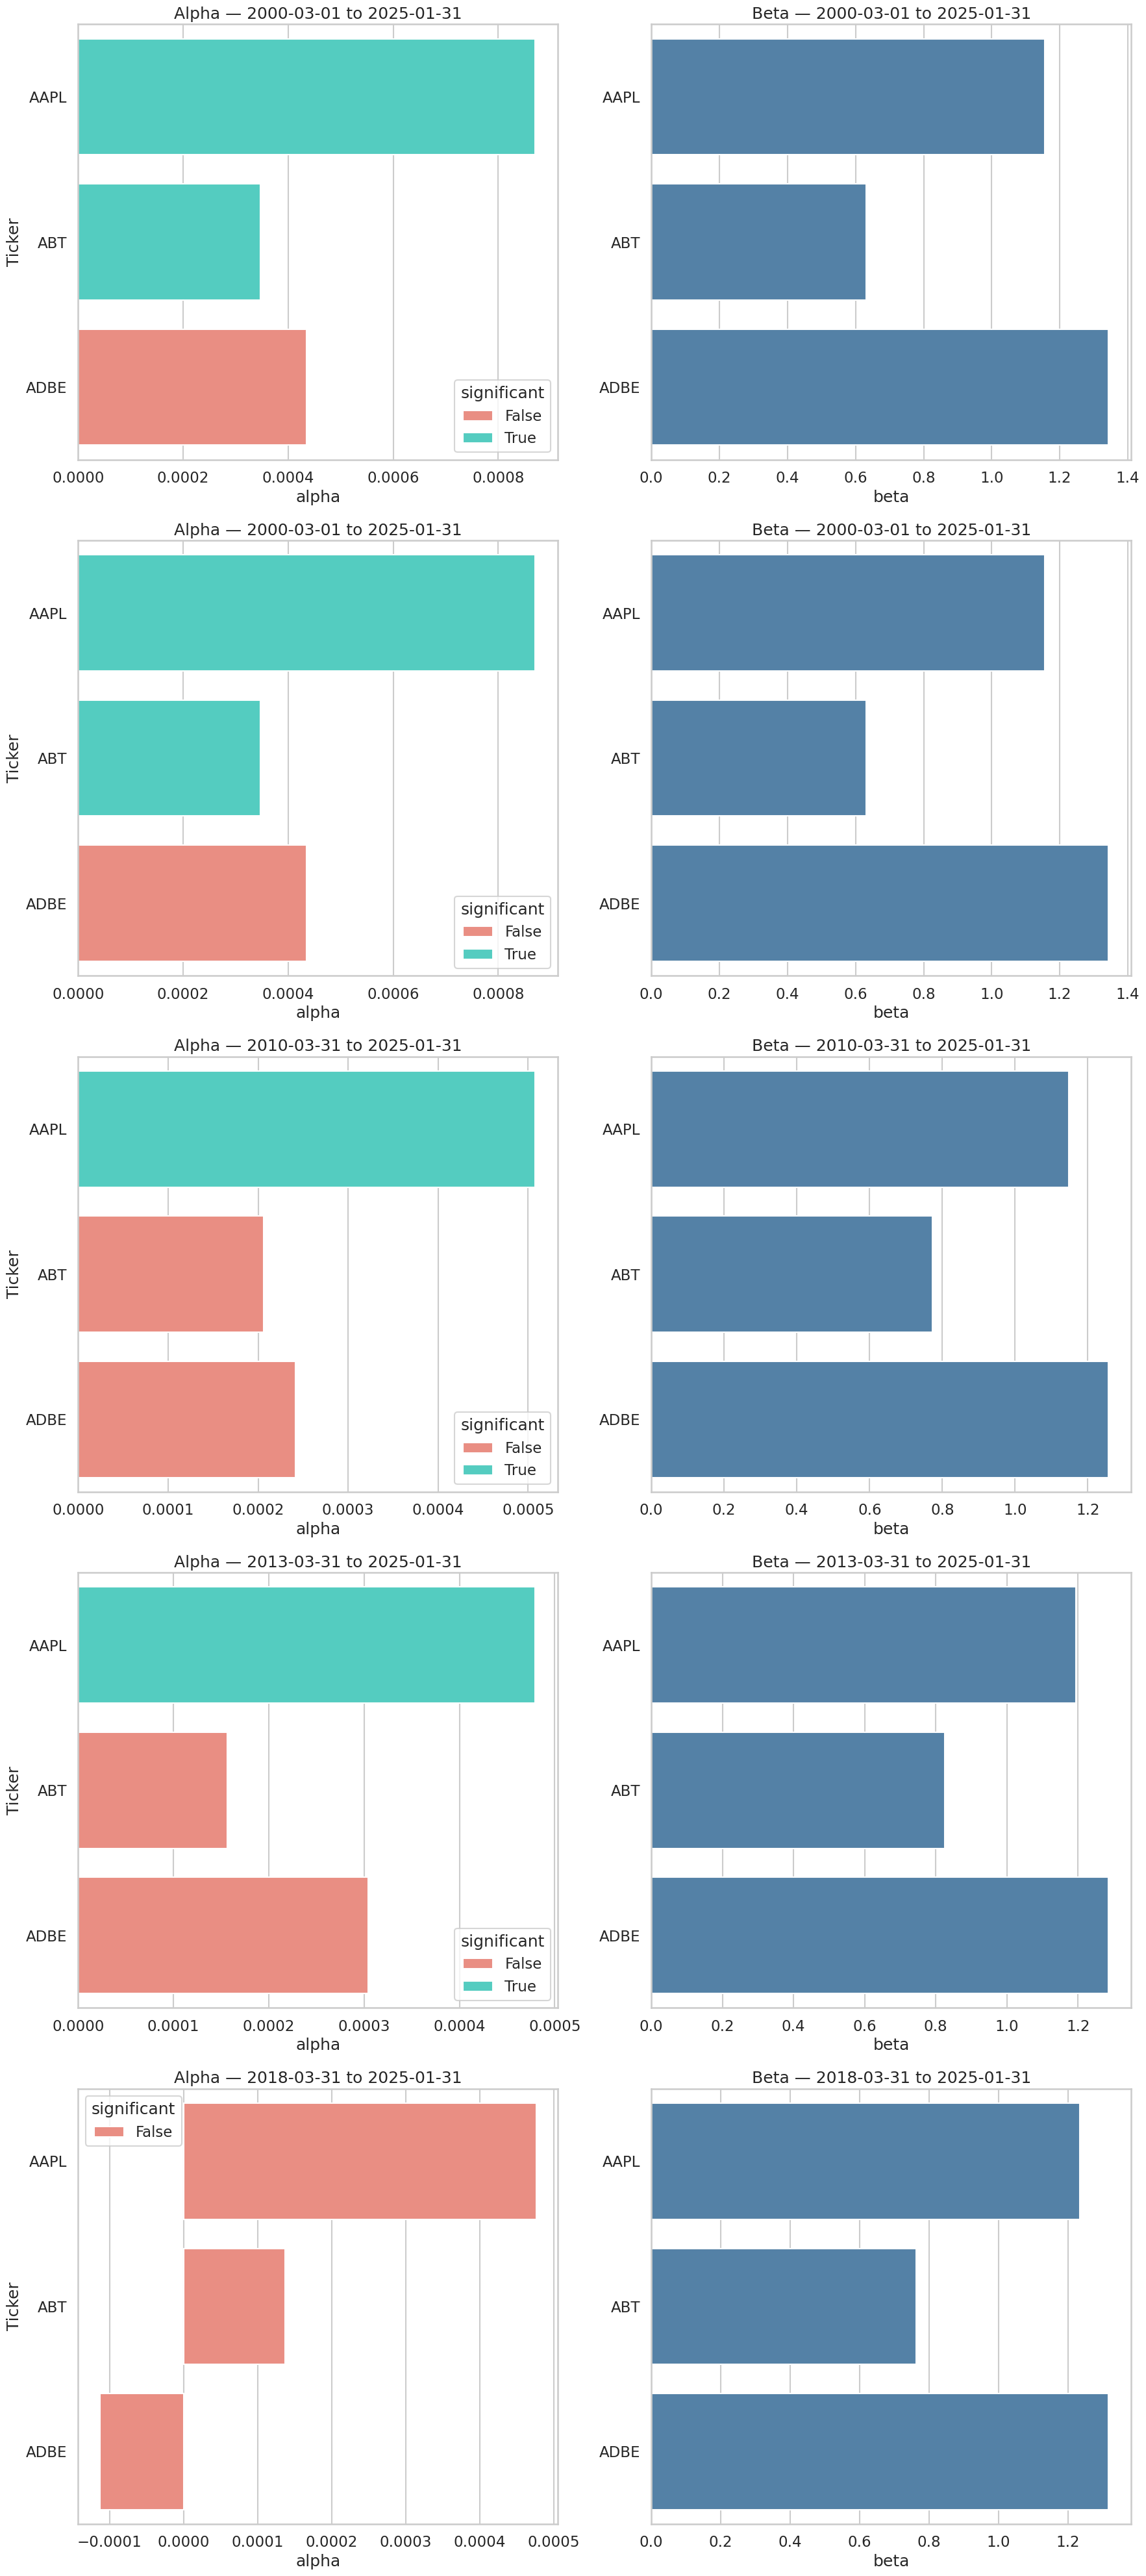

In [109]:
fig, axes = plt.subplots(5, 2, figsize=(18, 40))
plt.subplots_adjust(hspace=0.4)

for idx, start in enumerate(starts):
    first = excel_first_pass(RP_aligned, start, END)
    first = first.dropna()
    top3 = first.iloc[:3].copy()

    # === Alpha significance ===
    RM = RP_aligned['OEX_rp'].loc[start:END]
    RM_mean = RM.mean()
    RM_var = RM.var(ddof=1)
    N = len(RM)

    top3['alpha_se'] = np.sqrt(top3['sigma2'] * (1 + (RM_mean**2)/RM_var) / N)
    top3['tstat'] = top3['alpha'] / top3['alpha_se']
    top3['pval'] = 2*(1 - tdist.cdf(np.abs(top3['tstat']), df=N-2))
    top3['significant'] = top3['pval'] < 0.05

    # === LEFT subplot: ALPHA ===
    ax1 = axes[idx, 0]
    sns.barplot(
        data=top3, x='alpha', y='Ticker',
        hue='significant',
        palette={True:'turquoise', False:'salmon'},
        ax=ax1
    )
    ax1.set_title(f"Alpha — {start} to {END}")
    ax1.set_xlabel("alpha")
    ax1.set_ylabel("Ticker")

    # === RIGHT subplot: BETA ===
    ax2 = axes[idx, 1]
    sns.barplot(
        data=top3, x='beta', y='Ticker',
        color='steelblue',
        ax=ax2
    )
    ax2.set_title(f"Beta — {start} to {END}")
    ax2.set_xlabel("beta")
    ax2.set_ylabel("")

plt.tight_layout()
plt.savefig("src/alpha-beta-multiwindow-daily.svg")
plt.show()

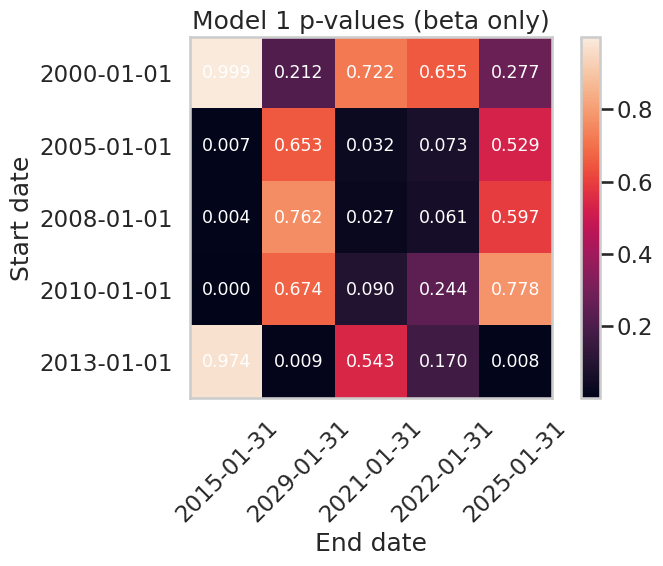

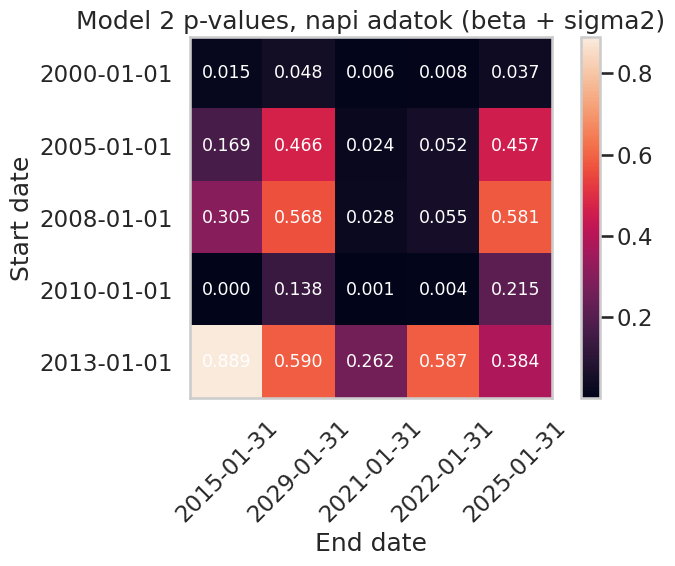

In [128]:
def excel_first_pass(RP,start,end):
    RPsub = RP.loc[start:end]
    RM = RPsub['OEX_rp']
    rows = []
    for s in RPsub.columns:
        if s == 'OEX_rp': continue
        Ri = RPsub[s]
        cov = np.cov(Ri, RM)[0,1]
        var = np.var(RM, ddof=1)
        beta = cov/var
        alpha = Ri.mean() - beta*RM.mean()
        sigma2 = np.var(Ri - beta*RM)
        rows.append([s, beta, alpha, sigma2, Ri.mean()])
    return pd.DataFrame(rows, columns=['Ticker','beta','alpha','sigma2','riskprem_mean'])

starts = [
    "2000-01-01",
    "2005-01-01",
    "2008-01-01",
    "2010-01-01",
    "2013-01-01"
]

ends = [
    "2015-01-31",
    "2029-01-31",
    "2021-01-31",
    "2022-01-31",
    "2025-01-31"
]

pvals1 = np.zeros((5,5))
pvals2 = np.zeros((5,5))

# === MAIN LOOP: 25 COMBINATIONS ===
for i, s in enumerate(starts):
    for j, e in enumerate(ends):

        first = excel_first_pass(RP_aligned, s, e)
        valid = first.set_index('Ticker').dropna()
        y = valid['riskprem_mean']

        # Model 1
        X1 = sm.add_constant(valid[['beta']])
        model1 = sm.OLS(y, X1).fit()

        # Model 2
        X2 = sm.add_constant(valid[['beta','sigma2']])
        model2 = sm.OLS(y, X2).fit()

        market_rp = RP_aligned['OEX_rp'].loc[s:e].mean()
        n = valid.shape[0]

        # Model 1 p-value
        gamma1_1 = model1.params['beta']
        se1 = model1.bse['beta']
        df1 = n - 2
        t1 = (gamma1_1 - market_rp)/se1
        p1 = 2*(1 - tdist.cdf(abs(t1), df1))

        # Model 2 p-value
        gamma1_2 = model2.params['beta']
        se2 = model2.bse['beta']
        df2 = n - 3
        t2 = (gamma1_2 - market_rp)/se2
        p2 = 2*(1 - tdist.cdf(abs(t2), df2))

        pvals1[i,j] = p1
        pvals2[i,j] = p2

# === HEATMAP FUNCTION ===
def plot_heatmap(mat, title):
    plt.figure(figsize=(8,6))
    im = plt.imshow(mat)
    plt.colorbar(im)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            plt.text(j, i, f'{mat[i,j]:.3f}', ha='center', va='center', color='white', size='x-small')
    plt.title(title)
    plt.xticks(range(5), [e[:10] for e in ends], rotation=45)
    plt.yticks(range(5), [s[:10] for s in starts])
    plt.xlabel("End date")
    plt.ylabel("Start date")
    plt.grid()
    plt.tight_layout()
    plt.savefig("src/heatmap-daily.svg")
    plt.show()

# === PRODUCE HEATMAPS ===
plot_heatmap(pvals1, "Model 1 p-values (beta only)")
plot_heatmap(pvals2, "Model 2 p-values, napi adatok (beta + sigma2)")


In [121]:
# === HETI ADATOK ===

# === LOAD DATA ===
df = pd.read_csv(r'data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').sort_index()

# Resample prices to week-end (last available price in each week)
prices_w = df.drop(columns=['TB1M']).resample('W-FRI').last()

# Resample TB1M to week-end
rf_yield = df['TB1M'].resample('W-FRI').last()   # TB1M is an annualized % yield

# Convert TB1M to monthly risk-free return
# If TB1M is annualized simple yield (common), weekly RF ≈ yield/12
rf_w = (rf_yield / 100) / 52                 # weekly risk-free rate
rf_w_lag = rf_w.shift(1)

# Simple weekly returns
returns_w = prices_w / prices_w.shift(1) - 1

# Risk premia
RP_w = returns_w.sub(rf_w_lag, axis=0).rename(columns={'OEX': 'OEX_rp'})

# Drop NA
RP_w_aligned = RP_w.dropna(how='any')

RP_w_aligned.head()

,OEX_rp,AAPL,ABT,ADBE,AIG,AMD,AMGN,AMT,AMZN,AXP,...,TMO,TXN,UNH,UNP,UPS,USB,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-14,0.016872,0.008387,-0.024426,0.023097,0.040632,0.241273,0.003561,0.221410,-0.077405,0.045296,...,-0.009509,0.146572,0.004062,0.015518,0.039455,0.071011,-0.043542,0.064461,-0.059429,-0.015016
2000-01-21,-0.023284,0.107237,-0.097055,-0.052878,-0.089808,-0.062960,0.092281,0.130107,-0.035087,-0.050021,...,-0.013861,0.026045,-0.053779,-0.051244,-0.027284,-0.068245,0.065553,-0.122480,-0.033017,0.013885
2000-01-28,-0.054580,-0.088082,0.020992,-0.085545,-0.019693,-0.070359,-0.201889,-0.124240,-0.007094,0.042211,...,0.124489,-0.033823,-0.099553,-0.072481,-0.035438,0.024884,-0.041635,0.056969,-0.118169,-0.073111
2000-02-04,0.049683,0.061645,0.079306,0.284473,-0.013342,0.092885,0.081636,0.068335,0.272470,0.019056,...,0.071990,0.231119,0.077298,-0.008778,-0.132944,0.001723,0.015183,-0.000482,0.020456,0.024270
2000-02-11,-0.031354,0.005853,-0.013795,0.221038,-0.060023,0.178812,-0.032038,0.093190,-0.031321,-0.050258,...,-0.076359,0.041524,-0.014306,-0.089463,-0.023263,-0.006693,-0.044848,-0.018919,-0.005530,-0.082524


In [122]:
# === HAVI ADATOK ===

# === LOAD DATA ===
df = pd.read_csv(r'data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').sort_index()

# Resample prices to week-end (last available price in each week)
prices_m = df.drop(columns=['TB1M']).resample('ME').last()

# Resample TB1M to week-end
rf_yield = df['TB1M'].resample('ME').last()   # TB1M is an annualized % yield

# Convert TB1M to monthly risk-free return
# If TB1M is annualized simple yield (common), monthly RF ≈ yield/12
rf_m = (rf_yield / 100) / 12                 # monthéy risk-free rate
rf_m_lag = rf_m.shift(1)

# Simple weekly returns
returns_m = prices_m / prices_m.shift(1) - 1

# Risk premia
RP_m = returns_m.sub(rf_m_lag, axis=0).rename(columns={'OEX': 'OEX_rp'})

# Drop NA
RP_m_aligned = RP_m.dropna(how='any')

RP_m_aligned.head()

,OEX_rp,AAPL,ABT,ADBE,AIG,AMD,AMGN,AMT,AMZN,AXP,...,TMO,TXN,UNH,UNP,UPS,USB,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-29,-0.025509,0.100020,0.008636,0.847640,-0.157495,0.092422,0.065858,0.368023,0.061996,-0.190307,...,-0.102273,0.536963,-0.040178,-0.060701,-0.091557,-0.258727,-0.214689,-0.173717,-0.114389,-0.090958
2000-03-31,0.098644,0.180025,0.061472,0.086750,0.234047,0.488854,-0.104725,-0.002279,-0.032040,0.105104,...,0.299184,-0.041686,0.162071,0.030696,0.148215,0.292019,0.244225,0.227698,0.155616,0.030868
2000-04-30,-0.046173,-0.091417,0.092942,0.081568,-0.003188,0.478151,-0.092476,-0.061862,-0.181206,0.000606,...,-0.053980,0.013362,0.113549,0.071777,0.050917,0.079569,-0.017288,0.002769,-0.024812,-0.008907
2000-05-31,-0.030278,-0.327772,0.053687,-0.074101,0.021812,-0.070564,0.131310,-0.207534,-0.129425,0.078762,...,-0.046786,-0.117667,0.113238,0.004053,-0.101899,0.022788,-0.123599,0.103019,0.035782,0.073377
2000-06-30,0.032995,0.242332,0.090546,0.150455,0.039173,-0.059738,0.099434,0.118204,-0.253075,-0.039414,...,0.129989,-0.054000,0.145350,-0.125500,-0.020872,-0.174701,-0.043699,-0.148338,-0.003600,-0.062456


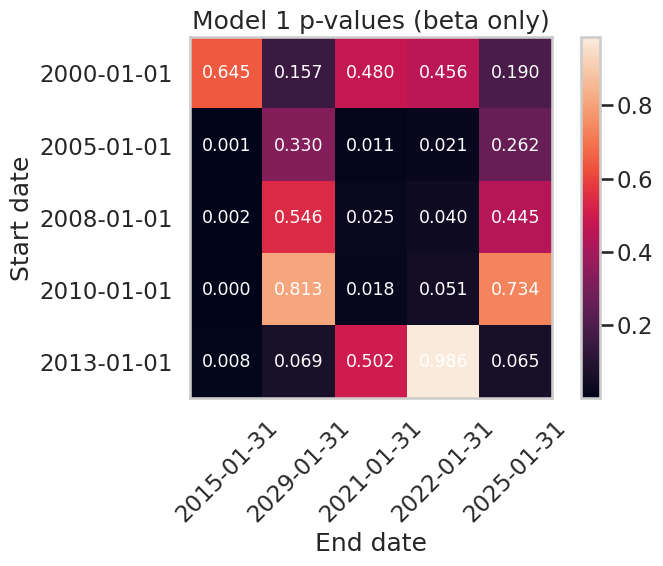

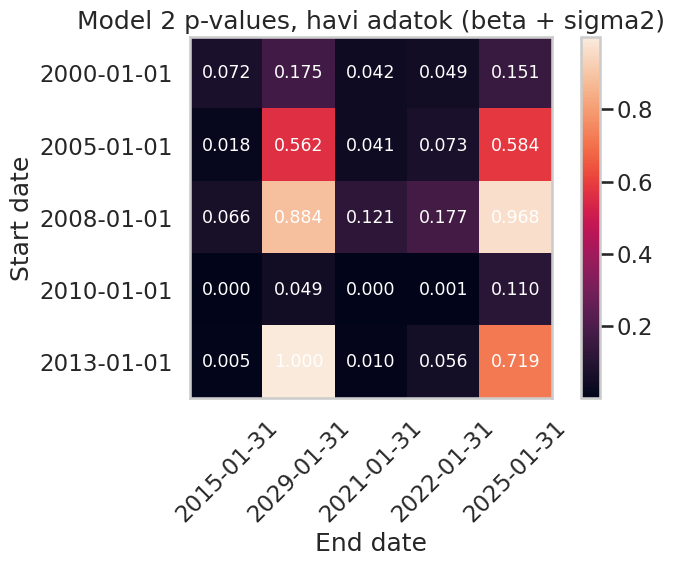

In [127]:
def excel_first_pass(RP,start,end):
    RPsub = RP.loc[start:end]
    RM = RPsub['OEX_rp']
    rows = []
    for s in RPsub.columns:
        if s == 'OEX_rp': continue
        Ri = RPsub[s]
        cov = np.cov(Ri, RM)[0,1]
        var = np.var(RM, ddof=1)
        beta = cov/var
        alpha = Ri.mean() - beta*RM.mean()
        sigma2 = np.var(Ri - beta*RM)
        rows.append([s, beta, alpha, sigma2, Ri.mean()])
    return pd.DataFrame(rows, columns=['Ticker','beta','alpha','sigma2','riskprem_mean'])

starts = [
    "2000-01-01",
    "2005-01-01",
    "2008-01-01",
    "2010-01-01",
    "2013-01-01"
]

ends = [
    "2015-01-31",
    "2029-01-31",
    "2021-01-31",
    "2022-01-31",
    "2025-01-31"
]

pvals1 = np.zeros((5,5))
pvals2 = np.zeros((5,5))

# === MAIN LOOP: 25 COMBINATIONS ===
for i, s in enumerate(starts):
    for j, e in enumerate(ends):

        first = excel_first_pass(RP_w_aligned, s, e)
        valid = first.set_index('Ticker').dropna()
        y = valid['riskprem_mean']

        # Model 1
        X1 = sm.add_constant(valid[['beta']])
        model1 = sm.OLS(y, X1).fit()

        # Model 2
        X2 = sm.add_constant(valid[['beta','sigma2']])
        model2 = sm.OLS(y, X2).fit()

        market_rp = RP_w_aligned['OEX_rp'].loc[s:e].mean()
        n = valid.shape[0]

        # Model 1 p-value
        gamma1_1 = model1.params['beta']
        se1 = model1.bse['beta']
        df1 = n - 2
        t1 = (gamma1_1 - market_rp)/se1
        p1 = 2*(1 - tdist.cdf(abs(t1), df1))

        # Model 2 p-value
        gamma1_2 = model2.params['beta']
        se2 = model2.bse['beta']
        df2 = n - 3
        t2 = (gamma1_2 - market_rp)/se2
        p2 = 2*(1 - tdist.cdf(abs(t2), df2))

        pvals1[i,j] = p1
        pvals2[i,j] = p2

# === HEATMAP FUNCTION ===
def plot_heatmap(mat, title):
    plt.figure(figsize=(8,6))
    im = plt.imshow(mat)
    plt.colorbar(im)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            plt.text(j, i, f'{mat[i,j]:.3f}', ha='center', va='center', color='white', size='x-small')
    plt.title(title)
    plt.xticks(range(5), [e[:10] for e in ends], rotation=45)
    plt.yticks(range(5), [s[:10] for s in starts])
    plt.xlabel("End date")
    plt.ylabel("Start date")
    plt.grid()
    plt.tight_layout()
    plt.savefig("src/heatmap-weekly.svg")
    plt.show()

# === PRODUCE HEATMAPS ===
plot_heatmap(pvals1, "Model 1 p-values (beta only)")
plot_heatmap(pvals2, "Model 2 p-values, havi adatok (beta + sigma2)")

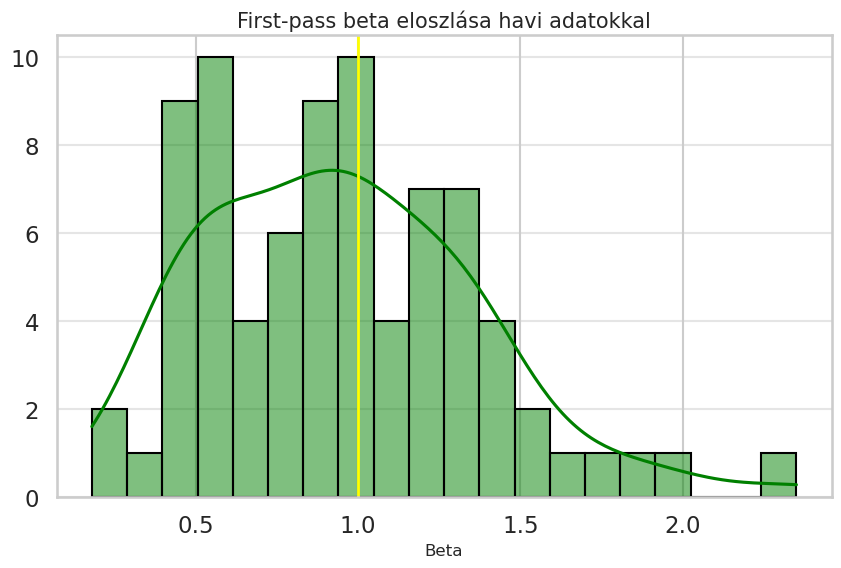

First-pass regresszió eredményei (első 5 sor):
  Ticker      beta     alpha    sigma2  riskprem_mean
0   AAPL  1.374741  0.017917  0.008275       0.023920
1    ABT  0.510924  0.006916  0.002736       0.009147
2   ADBE  1.333599  0.008939  0.008774       0.014762
3    AIG  1.602294 -0.000667  0.033977       0.006330
4    AMD  2.349371  0.013656  0.024338       0.023915
Beta átlaga: 0.9476643435727915


In [123]:
first_pass_results = excel_first_pass(RP_m_aligned, '2000-01-01', '2025-11-01')

# Hisztogram készítése
plt.figure(figsize=(10, 6))
sns.histplot(data=first_pass_results, x='beta', bins=20, kde=True, color='green', edgecolor='black')

# Díszítés
plt.title('First-pass beta eloszlása havi adatokkal', fontsize=15)
plt.xlabel('Beta', fontsize=12)
plt.ylabel('')
plt.axvline(x=1, color='yellow', linewidth=2)
plt.grid(axis='y', alpha=0.5)
plt.savefig('src/betaeloszl-monthly2000-2025.svg')
plt.show()

# Eredmények kiírása ellenőrzésképp
print("First-pass regresszió eredményei (első 5 sor):")
print(first_pass_results.head())
print(f"Beta átlaga: {np.mean(first_pass_results['beta'])}")